

# **Image Processing and Crop Stress Detection**


> **by Haripriya N**



This notebook consists of image processing codes, the image was taken in the first week of Jan 2020, stitched in Agisoft. The crop(wheat) is about 60 days old.




In [ ]:
pip install rasterio

     |████████████████████████████████| 18.3MB 1.2MB/s 


In [ ]:
import rasterio
import gdal

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
filepath = '/content/drive/My Drive/data/ortho.jpg'

/usr/local/lib/python3.6/dist-packages/rasterio/__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


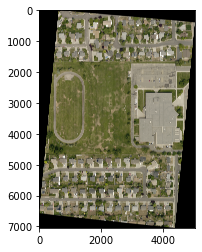

In [ ]:
# Plotting in Rasterio shows lat-lon values of the image

from rasterio.plot import show
im = rasterio.open(filepath)
show(im)

In [ ]:
# Details of the image can be obtained through raster image

print("Raster_data_name:      ",im.name)
print("Raster_data_width:     ",im.width)
print("Raster_data_height:    ",im.height)
# The info given below is used on opencv plots later..
print("Raster_data_bounds:    ",im.bounds)

Raster_data_name:       /content/drive/My Drive/data/ortho.jpg
Raster_data_width:      5049
Raster_data_height:     7046
Raster_data_bounds:     BoundingBox(left=0.0, bottom=7046.0, right=5049.0, top=0.0)


### **Converting Image to array(matrix)**




In [ ]:
# Function to convert image of n bands to array of n dimension all together

img_array = []

def Geotiff_to_array(image_filepath):
    image = gdal.Open(image_filepath)
    #START RANGE FROM 1
    for i in range(1,image.RasterCount+1):
        img = image.GetRasterBand(i)
        raster = img.ReadAsArray()
        img_array.append(raster)
    return img_array

In [ ]:
AA = Geotiff_to_array(filepath)

#### The image consists of bands arranged in this order:
0. Blue
1. Green
2. Red
3. Red Edge
4. NIR
5. Thermal

## **Image Masking**

The shape of a plot neednot be a perfect square or rectangle, therefore "polygon" with any number of edges can be considered here..
*Possiblity of masking with mouseclick is mentioned in the last

#### **Masking by selecting points manually**

In [ ]:
import pylab as plt
import numpy as np
from matplotlib.path import Path
import cv2
import matplotlib.pyplot as plt

In [ ]:
#######################MASK IMAGE######################

def mask_image(img, points):
    height,width = img.shape #add 'dim' next to width if needed
    polygon = points
    poly_path=Path(polygon)

    x, y = np.mgrid[:height, :width]
    coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1)))
    mask1 = poly_path.contains_points(coors)
    mask2 = mask1.reshape(height, width)
    mask = (mask2*255).astype(np.uint8)
    # plt.imshow(mask)

    timg = cv2.bitwise_or(img,img,mask=mask)
    # plt.imshow(img)
    return timg

In [ ]:
######### INDIVIDUAL ARRAY BANDS (full)########################

img_arr = img_array.copy()
#nir = img_arr[4]
#nir = nir.astype(float)
red = img_arr[2]
red = red.astype(float)
green = img_arr[1]
green = green.astype(float)
blue = img_arr[0]
blue = blue.astype(float)
#red_edge = img_arr[3]
#red_edge = red_edge.astype(float)
#thermal = img_arr[5]
#thermal = thermal.astype(float)

In [ ]:
import numpy as np
R = np.average(red)
G = np.average(green)
B = np.average(blue)

In [ ]:
ChNRGB = green - red/2 - blue/2
A = ChNRGB.shape


In [ ]:
for i in range(0,A[0]):
  for j in range(0,A[1]):
    if ChNRGB[i][j]<=30:
      ChNRGB[i][j]=0




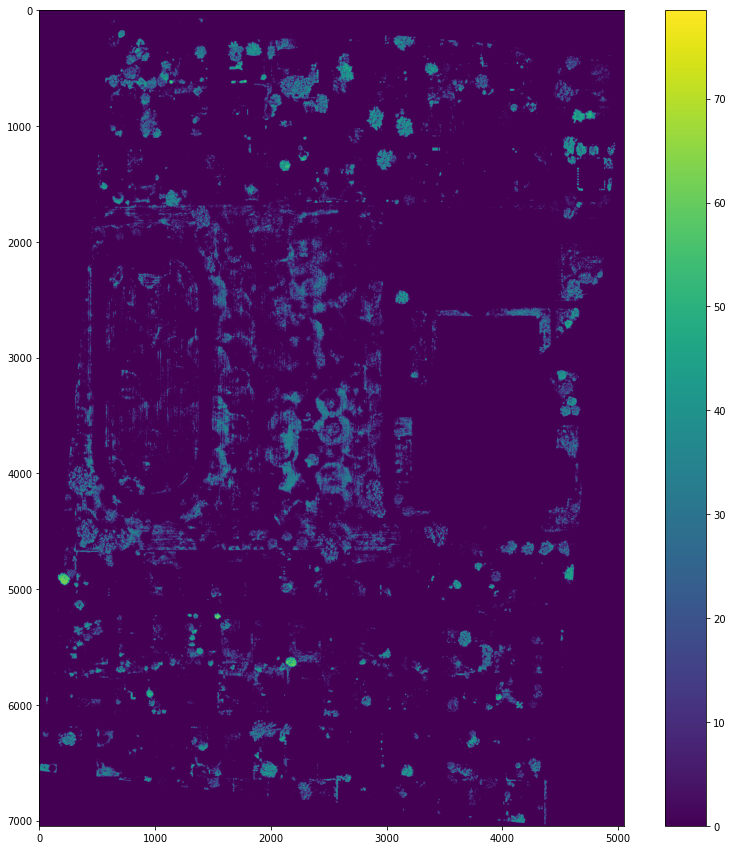

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
plt.imshow(ChNRGB)
plt.colorbar()


In [ ]:
points = ((1400,9800),(3550,10000),(5000,1000),(2800,800))

In [ ]:
######### INDIVIDUAL ARRAY BANDS (masked) #######################

blue = img_arr[0]
c_blue = mask_image(blue,points).astype(float)
green = img_arr[1]
c_green = mask_image(green,points).astype(float)
red = img_arr[2]
c_red = mask_image(red,points).astype(float)
red_edge = img_arr[3]
c_red_edge = mask_image(red_edge,points).astype(float)
nir = img_arr[4]
c_nir = mask_image(nir,points).astype(float)
thermal = img_arr[5]
c_thermal = mask_image(thermal,points).astype(float)

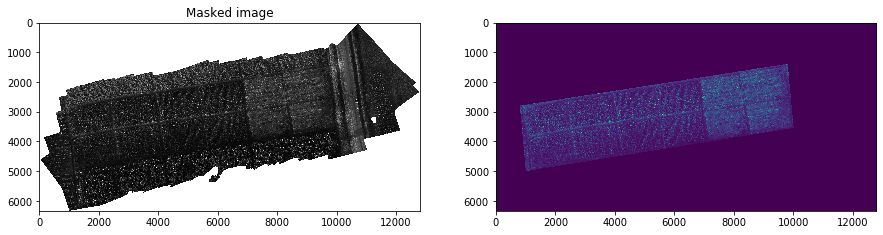

In [ ]:
# Masked VS Actual Image
###The second image is "masked" therefore has "black" pixels around the plot

import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
plt.title('Original image')
plt.subplot(121)
plt.imshow(img_array[0],cmap = 'gray')
plt.title('Masked image')
plt.subplot(122)
plt.imshow(c_blue)

### **Further Image processing..**

In [ ]:
## Alpha band correction included..Creating 255 intensity RGB image

rr = (((c_red / 65535.)**(1/1.9))*255).astype(np.uint8)
gg = (((c_green / 65535.)**(1/1.9))*255).astype(np.uint8)
bb = (((c_blue / 65535.)**(1/1.9))*255).astype(np.uint8)

In [ ]:
# Rotating the image to fit the plot

from scipy import ndimage

rotated_red = ndimage.rotate(rr, -9,reshape=True,order = 1)
rotated_green = ndimage.rotate(gg, -9,reshape=True,order = 1)
rotated_blue = ndimage.rotate(bb, -9,reshape=True,order = 1)

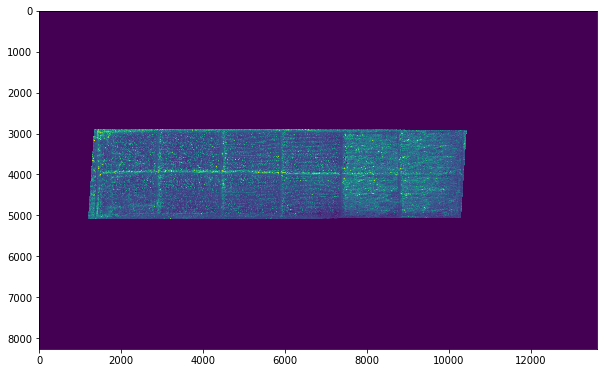

In [ ]:
# A sample before further cropping, the image is straightened

plt.figure(figsize=(10,10))
plt.imshow(rotated_red)

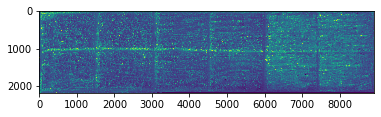

In [ ]:
# Final cropped output
# Obtaining the red band..

red_masked_cropped = rotated_red[2920:5100,1380:10300]
nir_masked_cropped = red_masked_cropped.astype('int64')
plt.imshow(nir_masked_cropped)

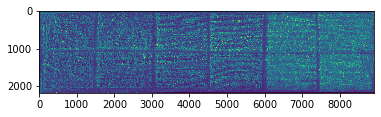

In [ ]:
#Green Band

green_masked_cropped = rotated_green[2920:5100,1380:10300]
green_masked_cropped = green_masked_cropped.astype('int64')
plt.imshow(green_masked_cropped)


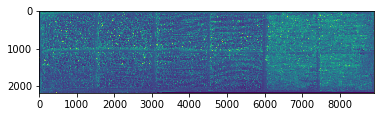

In [ ]:
# Blue..

blue_masked_cropped = rotated_blue[2920:5100,1380:10300]
blue_masked_cropped = blue_masked_cropped.astype('int64')
plt.imshow(blue_masked_cropped)


In [ ]:
red.dtype

dtype('uint16')

In [ ]:
# ** Data type conversion

red_ = (red_masked_cropped).astype(np.uint8)
green_ = (green_masked_cropped).astype(np.uint8)
blue_ = (blue_masked_cropped).astype(np.uint8)

In [ ]:
#Stacking to form RGB image..Though not an accurate image, useful for comparision

from scipy import ndimage
rgb = np.dstack((red_,green_,blue_))

In [ ]:
# An RGB image with pixel intensity 255

rgb.max()

255

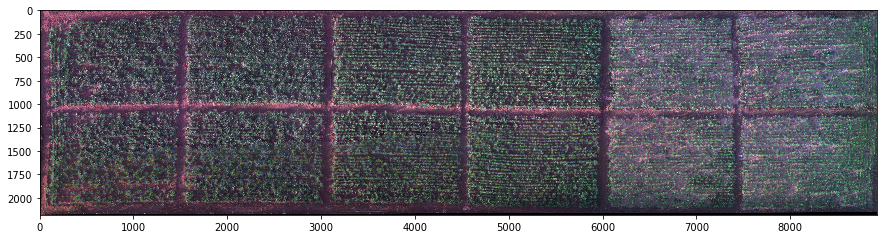

In [ ]:
#RGB image of max pixel intensity=255

plt.figure(figsize = (15,15))
plt.imshow(rgb)

#### This field has three treatments given to three sections of the plot, comparing the segments.
The three treatments are:
1. Zero Budget Natural Farming(ZBNF)
2. Organic
3. Recommended Package of Practice(RPP)

In [ ]:
# Creating three subdivisions of the above field

r_natural = rgb[0:2180,6000:8920]
r_govt_manure = rgb[0:2180,3100:6000]
r_exp_manure = rgb[0:2180,0:3050]

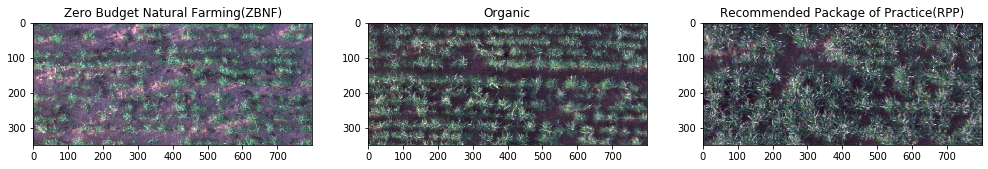

In [ ]:
#bgr image exclusively for opencv
one = rgb[500:850,6200:7000]
two = rgb[500:850,3200:4000]
three = rgb[500:850,1800:2600]
plt.figure(figsize=(17,17))

plt.subplot(131)
plt.title('Zero Budget Natural Farming(ZBNF)')
plt.imshow(one)
plt.subplot(132)
plt.title('Organic')
plt.imshow(two)
plt.subplot(133)
plt.title('Recommended Package of Practice(RPP)')
plt.imshow(three)

### **NDVI Calculation**


In [ ]:
## https://stackoverflow.com/questions/9041681/opencv-python-rotate-image-by-x-degrees-around-specific-point
from scipy import ndimage

#rotation angle in degree
rotated_red = ndimage.rotate(c_red, -9,reshape=True,order = 1)
rotated_nir = ndimage.rotate(c_nir, -9,reshape=True,order = 1)

In [ ]:
# NIR and RED are required to calculate NDVI

rotated_red = rotated_red.astype(int)
rotated_nir = rotated_nir.astype(int)

In [ ]:
red_masked_cropped = rotated_red[2920:5100,1380:10300]
red_masked_cropped = red_masked_cropped.astype('int64')

nir_masked_cropped = rotated_nir[2920:5100,1380:10300]
nir_masked_cropped = nir_masked_cropped.astype('int64')

In [ ]:
#red_masked_cropped.max()

In [ ]:
ndvi_cropped = (nir_masked_cropped-red_masked_cropped)/(nir_masked_cropped+red_masked_cropped)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [ ]:
nans = np.where(np.isnan(ndvi_cropped))

#Putting all the nan to zero
ndvi_cropped[nans]=0


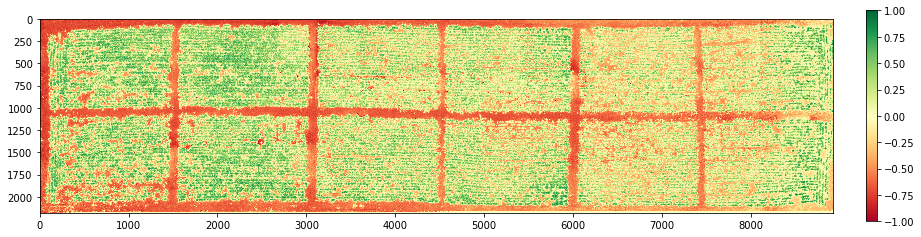

In [ ]:
plt.figure(figsize=(15,15))
im = plt.imshow(ndvi_cropped,cmap='RdYlGn')
plt.colorbar(im,fraction=0.0126, pad=0.04)
plt.show()

In [ ]:
natural = ndvi_cropped[0:2180,6000:8920]
govt_manure = ndvi_cropped[0:2180,3100:6000]
exp_manure = ndvi_cropped[0:2180,0:3050]

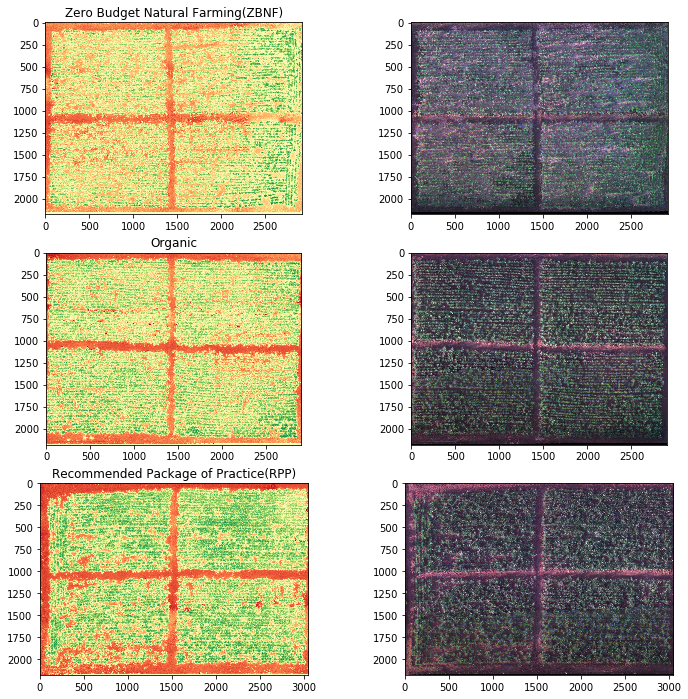

In [ ]:
# Individual treatment comparision of NDVI with original field

plt.figure(figsize=(12,12))
# plt.subplot(row,col,position)
plt.subplot(321)
plt.title('Zero Budget Natural Farming(ZBNF)')
plt.imshow(natural,cmap='RdYlGn')
plt.subplot(323)
plt.title('Organic')
plt.imshow(govt_manure,cmap='RdYlGn')
plt.subplot(325)
plt.title('Recommended Package of Practice(RPP)')
plt.imshow(exp_manure,cmap='RdYlGn')
plt.subplot(322)
plt.imshow(r_natural,cmap='RdYlGn')
plt.subplot(324)
plt.imshow(r_govt_manure,cmap='RdYlGn')
plt.subplot(326)
plt.imshow(r_exp_manure,cmap='RdYlGn')

In [ ]:
S1 = []
S2 = []
S3 = []

In [ ]:
row1,col1 = natural.shape

for i in range(row1):
  for j in range(col1):
    if natural[i][j]>0:
      S1.append(natural[i][j])

row2,col2 = govt_manure.shape

for i in range(row2):
  for j in range(col2):
    if govt_manure[i][j]>0:
      S2.append(govt_manure[i][j])


row3,col3 = exp_manure.shape

for i in range(row3):
  for j in range(col3):
    if exp_manure[i][j]>0:
      S3.append(exp_manure[i][j])

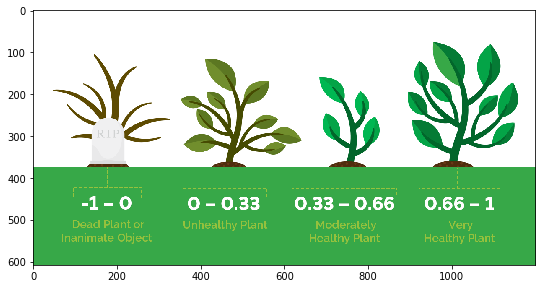

In [ ]:
from PIL import Image
A = Image.open('/content/drive/My Drive/Colab Notebooks/NDVI-Values-and-Plant-Health.png')
plt.figure(figsize=(9,9))
plt.imshow(A)

In [ ]:
# NDVI Values..
# The values are low because the crop is just days old

print("NDVI value of Zero Budget Natural Farming(ZBNF):   ", np.mean(S1))
print("NDVI value of Organic:                             ", np.mean(S2))
print("NDVI value of Recommended Package of Practice(RPP):", np.mean(S3))

NDVI value of Zero Budget Natural Farming(ZBNF):    0.2901889544422266
NDVI value of Organic:                              0.31265082941685
NDVI value of Recommended Package of Practice(RPP): 0.3781554250438853


In [ ]:
gi = []
gj = []
lgi = []
lgj = []

In [ ]:
# lets plot the parts where the plant is unhealthy and healthy in
# distinguishable colours

rows,col = ndvi_cropped.shape

for i in range(rows):
  for j in range(col):
    if ndvi_cropped[i][j]>0.3:
      gi.append(i)
      gj.append(j)
    elif 0.18<ndvi_cropped[i][j]<0.3:
      lgi.append(i)
      lgj.append(j)


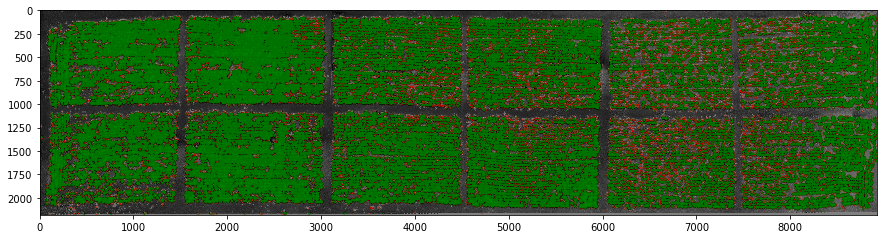

In [ ]:
plt.figure(figsize=(15,15))

plt.imshow(ndvi_cropped,cmap='gray')
plt.scatter(lgj,lgi,c = 'r',s = 0.0007)
plt.scatter(gj,gi,c = 'g',s = 0.0007)

plt.show()

In [ ]:
# A closer look at one of them..

In [ ]:
nir2 = nir_masked_cropped[0:1050,0:1500]
red2 = red_masked_cropped[0:1050,0:1500]
ndvi_small = (nir2-red2)/(nir2+red2)

In [ ]:
nans = np.where(np.isnan(ndvi_small))

#Putting all the nan to zero
ndvi_small[nans]=0

In [ ]:
gi = []
gj = []
lgi = []
lgj = []

In [ ]:
row,col = ndvi_small.shape

In [ ]:
for i in range(row):
  for j in range(col):
    if ndvi_small[i][j]>0.3:
      gi.append(i)
      gj.append(j)
    elif 0.1<ndvi_small[i][j]<0.28:
      lgi.append(i)
      lgj.append(j)


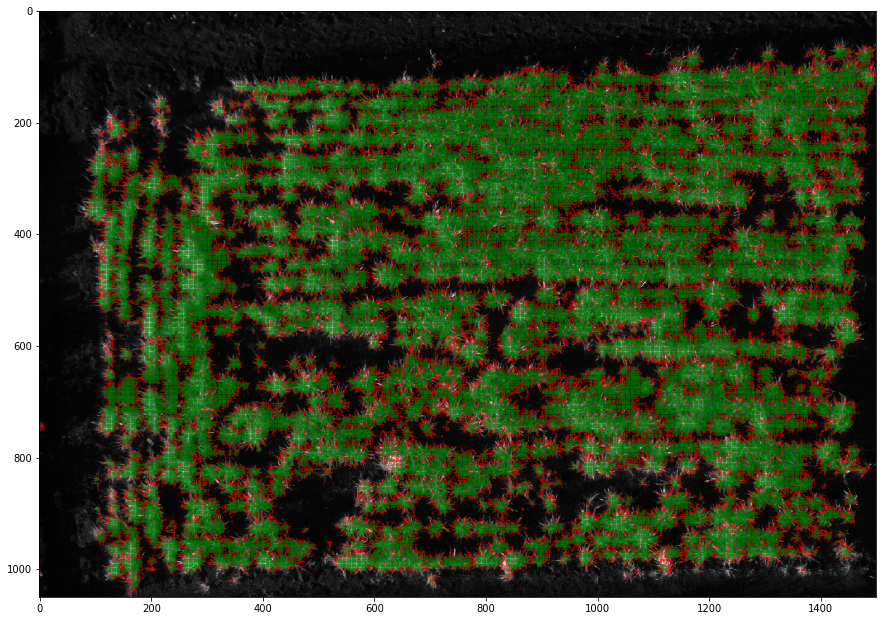

In [ ]:
plt.figure(figsize=(15,15))

plt.imshow(nir2,cmap='gray')
plt.scatter(lgj,lgi,c = 'r',s = 0.008)
plt.scatter(gj,gi,c = 'g',s = 0.008)
plt.show()

In [ ]:
from skimage import segmentation, color
from skimage.io import imread
from skimage.future import graph
from matplotlib import pyplot as plt

In [ ]:
new = np.where(ndvi_cropped<0,0,ndvi_cropped)

In [ ]:
new = new*255

In [ ]:
large_img_segments = segmentation.slic(new, compactness=20, n_segments=5000)
superpixels = color.label2rgb(large_img_segments, new, kind='avg')

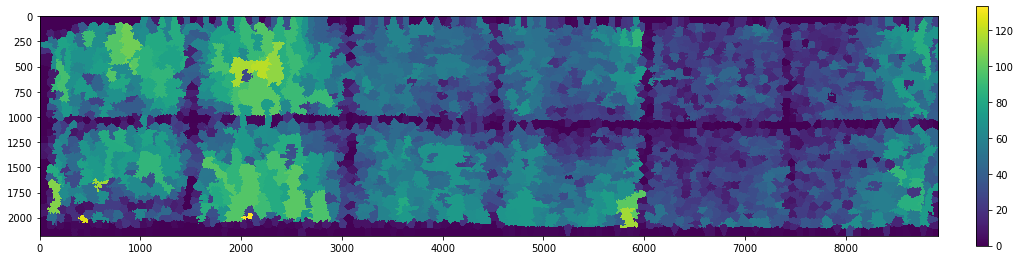

In [ ]:
plt.figure(figsize=(17,17))
A = plt.imshow(superpixels)
plt.colorbar(A,fraction=0.0126, pad=0.04)
plt.savefig("boxes.png")

In [ ]:
# The above image obtained after k-means clustering shows the clusters
# unhealthy and healthy parts of the field

In [ ]:
gi = []
gj = []
lgi = []
lgj = []

In [ ]:
row,col = superpixels.shape

for i in range(rows):
  for j in range(col):
    if superpixels[i][j]>40:
      gi.append(i)
      gj.append(j)
    elif 20<superpixels[i][j]<40:
      lgi.append(i)
      lgj.append(j)

### **The figure below shows the clusters of regions with        stresses**
the regions in black are either worse affected           plants or are not plants, there is more scope for improvement here.

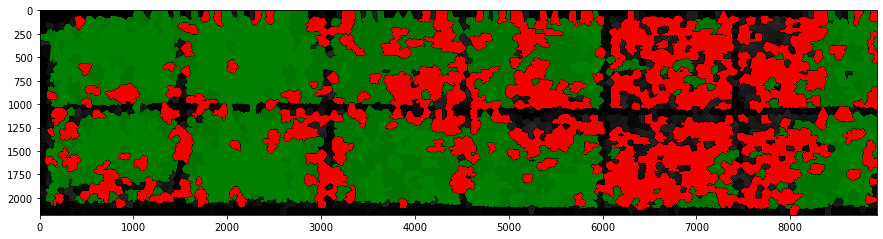

In [ ]:
plt.figure(figsize=(15,15))

plt.imshow(superpixels,cmap='gray')
plt.scatter(gj,gi,c = 'g',s = 0.0008)
plt.scatter(lgj,lgi,c = 'r',s = 0.0008)
plt.show()

# **Future Scope**

## 1. Plotting lat lon values.
Error correction in the readings is required to plot the GPS location which will be useful in ground truthing

In [ ]:
import pandas as pd
latlon = pd.read_excel('/content/drive/My Drive/latlon.xlsx',header=1)
latlon.head(10)

lat        lon
0  15.492639  74.989258
1  15.492697  74.989247
2  15.492664  74.989192
3  15.492625  74.989158
4  15.492694  74.989147
5  15.492625  74.989131
6  15.492678  74.989106
7  15.492653  74.989064
8  15.492606  74.989022
9  15.492669  74.989008

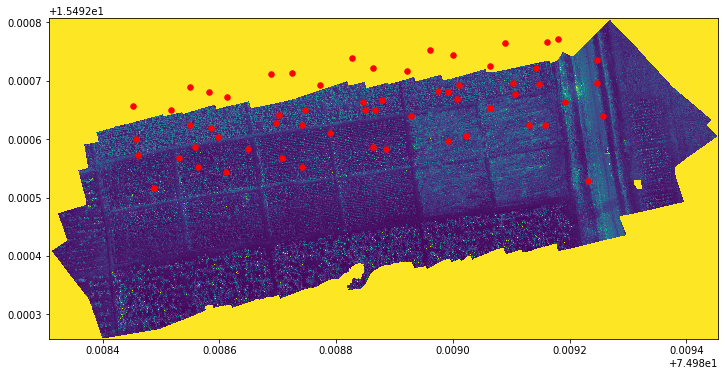

In [ ]:
from matplotlib import pyplot

array1 = img_array[0]
array1.shape
pyplot.figure(figsize=(12,12))
pyplot.imshow(array1,extent=[ 74.988308,74.989455,15.492258,15.492808])
pyplot.scatter(latlon.lon,latlon.lat,c = 'r',s = 30)
pyplot.show()


## 2. Analyzing the manually recorded field Data and building a learning algorithm.


##  3."Masking on mouseclick"
I have written this code but needs few modifications to be able to handle multispectral Images. Works effeciently on jpg/png/ndvi images

It can be run on the terminal as a python file:
1. On terminal run python filename.py.
2. Select the portion you want to mask using mouse.
3. Press Esc and confirm output image.
4. Press Esc again to close the window, look for "polygon.png" as your masked image.



In [ ]:
# import pylab as plt
# import numpy as np
# from matplotlib.path import Path
# import cv2
# import matplotlib.pyplot as plt

# import numpy as np
# import cv2
# A = "/image/path"
# # ============================================================================
# hei,wid = A.shape
# CANVAS_SIZE = (hei,wid)

# FINAL_LINE_COLOR = (255, 255, 255)
# WORKING_LINE_COLOR = (127, 127, 127)

# # ============================================================================

# class PolygonDrawer(object):
#     def __init__(self, window_name):
#         self.window_name = window_name # Name for our window

#         self.done = False # Flag signalling we're done
#         self.current = (0, 0) # Current position, so we can draw the line-in-progress
#         self.points = [] # List of points defining our polygon

In [ ]:
#     def on_mouse(self, event, x, y, buttons, user_param):
#         # Mouse callback that gets called for every mouse event (i.e. moving, clicking, etc.)

#         if self.done: # Nothing more to do
#             return


#         if event == cv2.EVENT_LBUTTONDOWN:
#             # Left click means adding a point at current position to the list of points
#             print("Adding point #%d with position(%d,%d)" % (len(self.points), x, y))
#             self.current = (x,y)
#             self.points.append((x, y))



#         elif event == cv2.EVENT_RBUTTONDOWN:
#             # Right click means we're done
#             print("Completing polygon with %d points." % len(self.points))
#             self.done = True


#     def run(self):
#         # Let's create our working window and set a mouse callback to handle events
#         cv2.namedWindow(self.window_name)
#         cv2.imshow(self.window_name, A)
#         cv2.waitKey(1)
#         cv2.setMouseCallback(self.window_name, self.on_mouse)



In [ ]:
#         while(not self.done):
#             # This is our drawing loop, we just continuously draw new images
#             # and show them in the named window
#             canvas = A
#             if (len(self.points) > 0):
#                 # Draw all the current polygon segments
#                 cv2.polylines(canvas, np.array([pd.points]), False, FINAL_LINE_COLOR, 1)
#                 cv2.line(canvas, self.points[-1], self.current, WORKING_LINE_COLOR)
#                 # And  also show what the current segment would look like

#             # Update the window
#             cv2.imshow(self.window_name, canvas)
#             # And wait 50ms before next iteration (this will pump window messages meanwhile)
#             if cv2.waitKey(50) == 27: # ESC hit
#                 self.done = True

#         # User finised entering the polygon points, so let's make the final drawing
#         canvas = A
#         # of a filled polygon
#         if (len(self.points) > 0):
#             height,width = A.shape
#             polygon = self.points
#             poly_path=Path(polygon)

#             y,x = np.mgrid[:height, :width]
#             coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1)))
#             mask1 = poly_path.contains_points(coors)
#             mask2 = mask1.reshape(width, height)
#             mask = (mask2*255).astype(np.uint8)
#             #cv2.fillPoly(canvas, np.array([self.points]))
#             masked = cv2.bitwise_or(canvas,canvas,mask = mask)
# #         # And show it
#         cv2.imshow(self.window_name, masked)
#         # Waiting for the user to press any key
#         cv2.waitKey()

#         cv2.destroyWindow(self.window_name)
#         return canvas

# # ============================================================================

# if __name__ == "__main__":
#     pd = PolygonDrawer("Polygon")
#     image = pd.run()
#     cv2.imwrite("polygon.png", image)
#     print("Polygon = %s" % pd.points)

##########################################################################################################################################################